# Ex 8

In [11]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from util_functions import (
    gaussian_1D_kernel,
)

(1999, 3229)


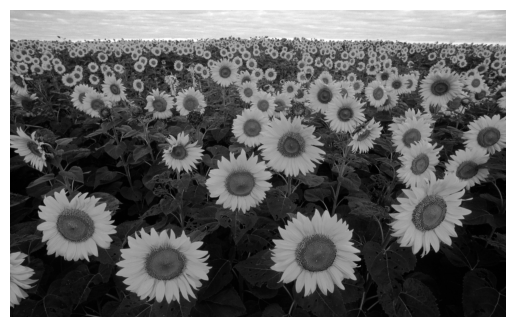

In [12]:
im = cv2.imread("media/sunflowers.jpg").astype(float).mean(2) / 255

# Display image
plt.imshow(im, cmap="gray")
plt.axis("off")
print(im.shape)

5
(1999, 3229)


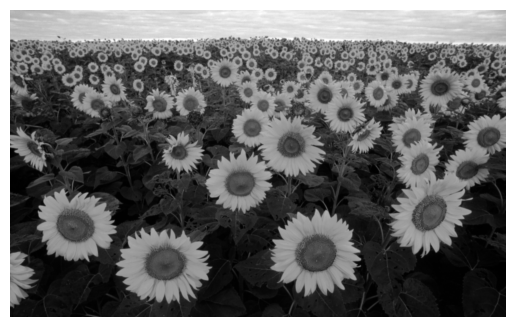

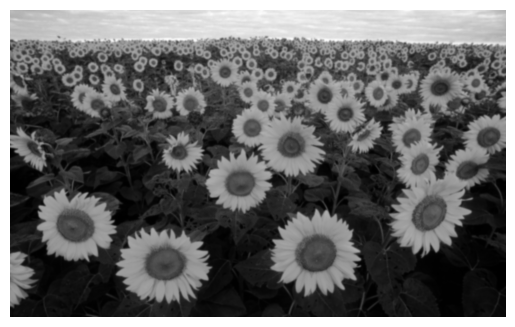

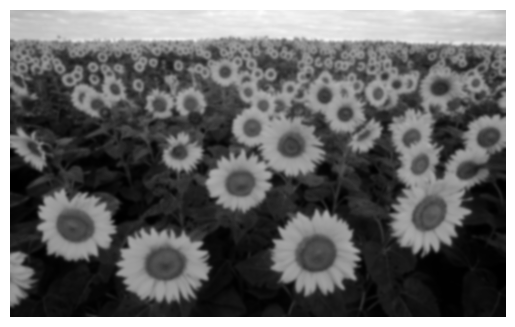

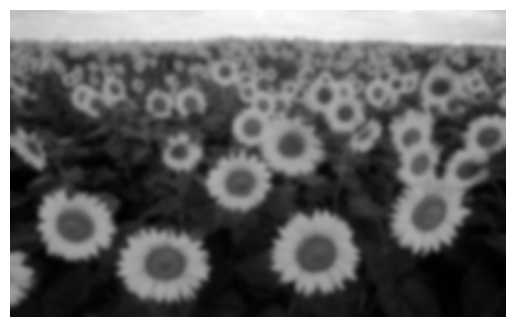

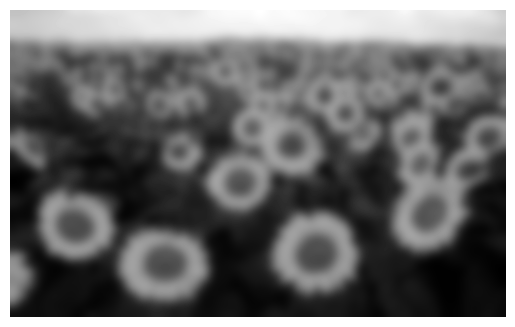

In [14]:
# Ex 8.1
def scale_spaced(im, sigma, n):
    """
    Naive implementation of the scale space pyramid with no downsampling.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        im_scales : list containing the scale space pyramid of the input image
        scales : list containing the scales used in the pyramid
    """
    print("Creating scale space pyramid...")
    exp = np.linspace(0, n - 1, n)
    scales = sigma * np.power(2, exp)
    im_scales = []
    for sd in scales:
        g, _ = gaussian_1D_kernel(sd)
        I = cv2.sepFilter2D(im, -1, g, g)
        im_scales.append(I)
    # im_scales = [gaussian_smoothing(im, sd)[0] for sd in sd_list] # very slow
    print("Done with scale space pyramid.")
    return im_scales, scales


im_scales, scales = scale_spaced(im, 2, 5)

# Check images in pyramid are exactly the same as the original image
print(len(im_scales))
print(im_scales[0].shape)

# Visualize images to check for progressive blur
for i, im_scale in enumerate(im_scales):
    # plt.subplot(5, 1, i+1)
    plt.imshow(im_scale, cmap="gray")
    plt.axis("off")
    plt.show()
plt.show()

In [16]:
# Ex 8.2
def difference_of_gaussians(im, sigma, n):
    """
    Implementation of the difference of Gaussians.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        DoG : list of scale space DoGs of im
        scales : list containing the scales used in the pyramid
    """
    print("Creating DoG...")
    im_scales, scales = scale_spaced(im, sigma, n)
    DoG = []
    for i in range(1, n):
        diff = im_scales[i] - im_scales[i - 1]
        DoG.append(diff)
    print("Done with DoG.")
    return DoG, scales


DoG, scales = difference_of_gaussians(im, 1, 5)

# Check images in pyramid are exactly the same as the original image
print(len(DoG))
print(DoG[0].shape)

4
(1999, 3229)


In [17]:
# Ex 8.3
def detect_blobs(im, sigma, n, tau):
    """
    Implementation of the blob detector.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales
        tau : threshold for blob detection

    Returns:
        blobs : list of detected blobs
    """
    print("Detecting blobs...")
    DoG, scales = difference_of_gaussians(im, sigma, n)

    # non-max suppression using a 3x3 max filter
    MaxDoG = [cv2.dilate(dog, np.ones((3, 3))) for dog in DoG]

    blobs = []
    for i in range(1, len(DoG) - 1):  # for each DoG, skip first & last
        for j in range(1, im.shape[0] - 1):  # for each row
            for k in range(1, im.shape[1] - 1):  # for each column
                if (
                    MaxDoG[i][j, k] > tau  # thresholding
                    and MaxDoG[i][j, k] > MaxDoG[i - 1][j, k]  # previous DoG
                    and MaxDoG[i][j, k] > MaxDoG[i + 1][j, k]
                ):  # next DoG
                    blobs.append((j, k, scales[i]))
    print("Done with blob detection.")
    return blobs


sigma = 2
n = 7
tau = 0.1
blobs = detect_blobs(im, sigma, n, tau)
print(len(blobs))

Detecting blobs...
Done with blob detection.
155346


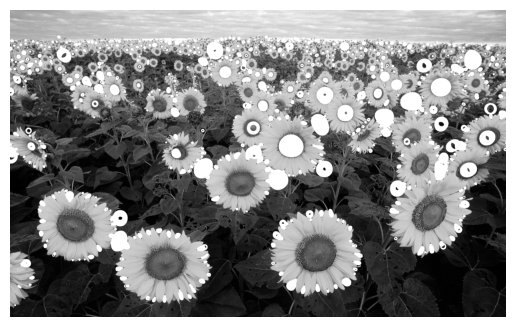

In [31]:
def visualize_blobs(blobs, im):
    im = cv2.imread("media/sunflowers.jpg")
    for x, y, scale in blobs:
        cv2.circle(im, (int(y), int(x)), int(scale), (255, 255, 255), 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im


im = visualize_blobs(blobs, im)
plt.imshow(im, cmap="gray")
plt.axis("off")
plt.show()

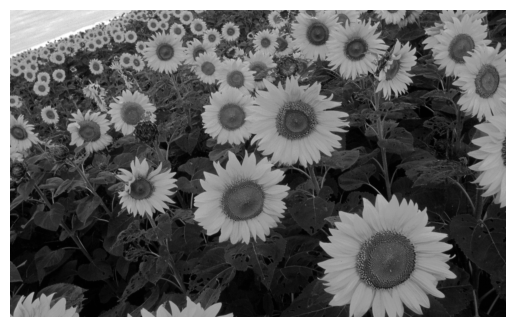

In [57]:
# Ex 8.4
def transform_im(im, theta, s):
    """
    Rotate an image by theta degrees and scale by s.

    Args:
        im : input image
        theta : angle of rotation
        s : scaling factor

    Returns:
        r_im : rotated and scaled image
    """
    rows, cols = im.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta, s)
    r_im = cv2.warpAffine(im, M, (cols, rows))
    return r_im


im = cv2.imread("media/sunflowers.jpg").astype(float).mean(2) / 255
r_im = transform_im(im, 20, 1.5)
plt.imshow(r_im, cmap="gray")
plt.axis("off")
plt.show()

In [58]:
# Ex 8.5
# Use SIFT detector to detect features in both original and transformed image.

# Read images as uint8
im = cv2.imread("media/sunflowers.jpg").mean(2).astype(np.uint8)
r_im = transform_im(im, 20, 1.5)

# SIFT detector
sift = cv2.SIFT_create()
kp1 = sift.detect(im, None)
kp2 = sift.detect(r_im, None)

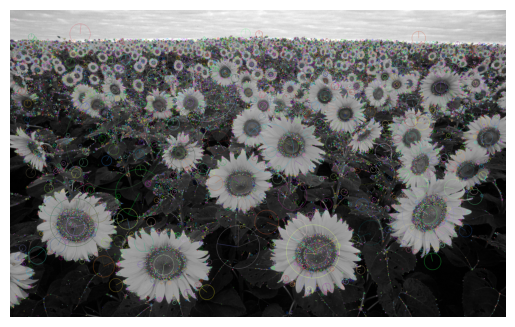

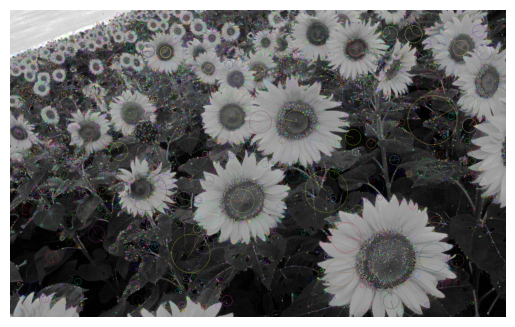

In [54]:
# Marking the keypoint on the image using circles
img = cv2.drawKeypoints(
    im, kp1, im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

r_img = cv2.drawKeypoints(
    r_im, kp2, r_im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Plot features in both images.
plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(r_img)
plt.axis("off")
plt.show()

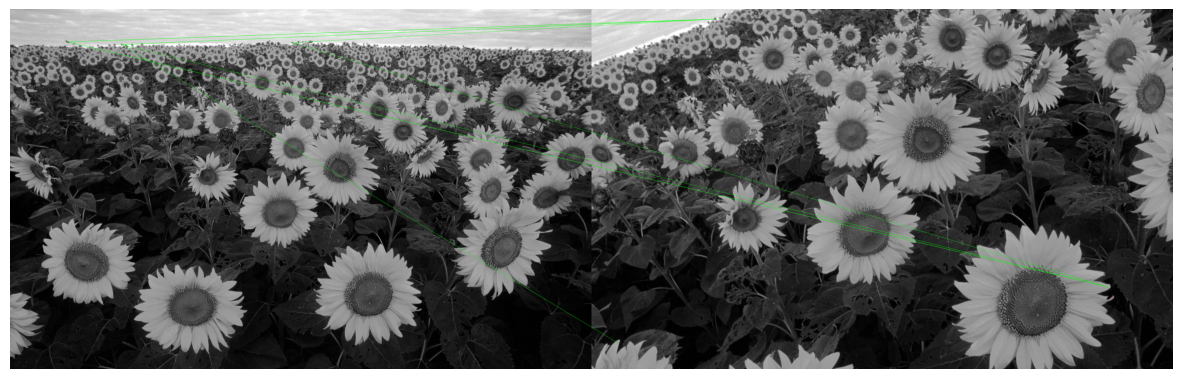

('good features',
 [[< cv2.DMatch 0000016A00E08850>],
  [< cv2.DMatch 0000016A00B95750>],
  [< cv2.DMatch 0000016A00B97A90>],
  [< cv2.DMatch 0000016A00B95430>],
  [< cv2.DMatch 0000016A00B9DA50>]])

In [74]:
def BFMatching(img1, img2):
    """
    Modified from https://www.geeksforgeeks.org/python-opencv-bfmatcher-function/
    """
    # Find the keypoints and descriptors
    sift = cv2.SIFT_create(5)
    # sift = cv2.ORB_create(5)
    kpnt1, des1 = sift.detectAndCompute(img1, None)
    kpnt2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default parameters
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    matched_image = cv2.drawMatchesKnn(
        img1,
        kpnt1,
        img2,
        kpnt2,
        matches,
        None,
        matchColor=(0, 255, 0),
        matchesMask=None,
        singlePointColor=(255, 0, 0),
        flags=0,
    )

    # Display matched image
    plt.imshow(matched_image)
    plt.axis("off")
    plt.show()

    # Creating a criteria for the good matches
    for m, n in matches:
        if m.distance < 0.98 * n.distance:
            good.append([m])

    return ("good features", good)  # returning ggod features


mpl.rcParams["figure.figsize"] = [15, 10]
BFMatching(im, r_im)